In [2]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/avanti/anacon

In [10]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.cast` instead.


In [11]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [17]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [25]:
inp_tensor = keras.layers.Input((None,4))
conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add1_out = keras.layers.Add()([conv1_out, conv2_out])
conv3_out =  get_out_tensor(inp_tensor=add1_out,
                            layer_to_copy=keras_model.layers[4],
                            param_overrides={'padding': 'same'})
add2_out = keras.layers.Add()([add1_out, conv3_out])
conv4_out =  get_out_tensor(inp_tensor=add2_out,
                            layer_to_copy=keras_model.layers[6],
                            param_overrides={'padding': 'same'})

conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)([conv1_gap, conv2_gap, conv3_gap, conv4_gap])
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [34]:
embedding_model.save("embedding_model.h5")

In [30]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 256)

In [31]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_5 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [32]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [33]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

/mnt/lab_data2/avanti/tfmodisco
commit 20e04f852f6d325f58b2fec20795a38070b879ab (HEAD -> filterembed, origin/filterembed)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu May 7 15:38:54 2020 -0700

    slightly nicer nb with scores summed across tasks
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1
MEMORY 6.69681664
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.00754788601747714
Computing threshold
Thresholds from null dist were -0.026598811149597168  and  0.2509317398071289
Passing windows frac was 0.04676685078463518 , which is above  0.03 ; adjusting
Final raw thresholds are -0.3184376752376554  and  0.3184376752376554
Final transformed thresholds are -0.9699999852203116  and  0.9699999852203116


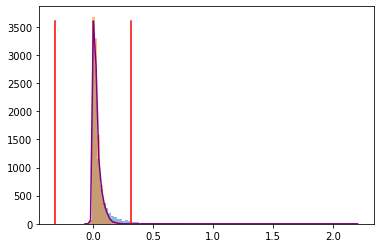

Got 98300 coords
After resolving overlaps, got 98300 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9698999852203116
MEMORY 7.376203776
98300 identified in total
1 activity patterns with support >= 2000 out of 3 possible patterns
Metacluster sizes:  [98297]
Idx to activities:  {0: '1'}
MEMORY 7.376658432
On metacluster 0
Metacluster size 98297 limited to 50000
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)


/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 50000
(Round 1) Computing coarse affmat
MEMORY 7.3788416
Beginning embedding computation
Finished embedding computation in 17.49 s
Starting affinity matrix computations
Normalization computed in 0.23 s
Cosine similarity mat computed in 15.86 s
Normalization computed in 0.21 s
Cosine similarity mat computed in 15.42 s
Finished affinity matrix computations in 49.43 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 17.387732992
Computed nearest neighbors in 180.25 s
MEMORY 18.205970432
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 18.205970432
Launching nearest neighbors affmat calculation job
MEMORY 18.376302592
Parallel runs completed
MEMORY 18.50990592
Job completed in: 325.98 s
MEMORY 38.040834048
Launching nearest neighbors affmat calculation job
MEMORY 38.034432
Parallel runs completed
MEMORY 38.149910528
Job completed in: 328.44 s
MEMORY 57.68093696
(Round 1) Computed affinity matrix

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7160482317945315


100%|██████████| 50/50 [1:02:56<00:00, 75.52s/it] 


Got 35 clusters after round 1
Counts:
{5: 3498, 7: 1975, 24: 65, 8: 879, 4: 4288, 11: 566, 0: 7674, 16: 300, 1: 7610, 3: 4433, 17: 188, 2: 5850, 6: 3034, 21: 85, 9: 683, 28: 21, 29: 20, 14: 371, 15: 311, 10: 667, 13: 429, 12: 507, 23: 75, 33: 9, 27: 22, 18: 134, 19: 117, 25: 52, 20: 89, 22: 76, 30: 17, 32: 14, 26: 45, 31: 14, 34: 7}
MEMORY 8.332419072
(Round 1) Aggregating seqlets in each cluster
MEMORY 8.332419072
Aggregating for cluster 0 with 7674 seqlets
MEMORY 8.332419072
Trimmed 0 out of 7674
Skipped 2 seqlets
Removed 154 duplicate seqlets
Aggregating for cluster 1 with 7610 seqlets
MEMORY 8.37361664
Trimmed 25 out of 7610
Skipped 1 seqlets
Removed 110 duplicate seqlets
Aggregating for cluster 2 with 5850 seqlets
MEMORY 8.40282112
Trimmed 123 out of 5850
Skipped 1 seqlets
Removed 36 duplicate seqlets
Removed 2 duplicate seqlets
Aggregating for cluster 3 with 4433 seqlets
MEMORY 8.371085312
Trimmed 170 out of 4433
Removed 17 duplicate seqlets
Removed 4 duplicate seqlets
Aggregatin

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7179707234683022


  4%|▍         | 2/50 [01:47<40:53, 51.11s/it]

Quality: 0.7210102694275062


 12%|█▏        | 6/50 [06:19<44:56, 61.28s/it]

Quality: 0.7214575240797049


 58%|█████▊    | 29/50 [33:40<24:40, 70.49s/it]

Quality: 0.7214829862503359


 92%|█████████▏| 46/50 [50:52<04:24, 66.10s/it]

Quality: 0.7215370084175395


100%|██████████| 50/50 [56:16<00:00, 67.52s/it]


Got 40 clusters after round 2
Counts:
{2: 5096, 1: 5323, 15: 262, 23: 119, 11: 367, 8: 1779, 20: 153, 5: 3910, 18: 231, 6: 3544, 12: 365, 3: 4769, 0: 5574, 4: 4193, 19: 155, 16: 245, 7: 2952, 22: 121, 21: 144, 9: 546, 28: 60, 25: 95, 27: 61, 17: 235, 30: 31, 10: 435, 26: 73, 14: 275, 24: 106, 13: 299, 29: 46, 39: 2, 37: 6, 35: 8, 31: 18, 38: 6, 36: 8, 32: 17, 33: 14, 34: 9}
MEMORY 8.401477632
(Round 2) Aggregating seqlets in each cluster
MEMORY 8.401477632
Aggregating for cluster 0 with 5574 seqlets
MEMORY 8.401477632
Trimmed 156 out of 5574
Skipped 1 seqlets
Removed 176 duplicate seqlets
Aggregating for cluster 1 with 5323 seqlets
MEMORY 8.431091712
Trimmed 27 out of 5323
Skipped 3 seqlets
Removed 382 duplicate seqlets
Aggregating for cluster 2 with 5096 seqlets
MEMORY 8.447512576
Trimmed 49 out of 5096
Skipped 1 seqlets
Removed 397 duplicate seqlets
Aggregating for cluster 3 with 4769 seqlets
MEMORY 8.455032832
Trimmed 63 out of 4769
Removed 217 duplicate seqlets
Aggregating for clus

After 2 runs, maximum modularity is Q = 0.00886945
After 3 runs, maximum modularity is Q = 0.00997306
Louvain completed 23 runs in 7.398226737976074 seconds
Similarity is 0.938237; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.1752176284790039 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00844517
Louvain completed 21 runs in 6.480236053466797 seconds
Similarity is -0.06255287; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.13544511795043945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00590654
Louvain completed 21 runs in 6.220556020736694 seconds
Similarity is -0.018726949; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.05049467086791992 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00238071
After 2 runs, maximum modularity is Q = 0.002

Similarity is 0.6857333; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.008105993270874023 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0102645
After 2 runs, maximum modularity is Q = 0.010621
After 4 runs, maximum modularity is Q = 0.0106386
Louvain completed 24 runs in 7.421123027801514 seconds
Similarity is 0.79182565; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.0039806365966796875 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00240614
After 3 runs, maximum modularity is Q = 0.00266303
After 5 runs, maximum modularity is Q = 0.0027113
After 6 runs, maximum modularity is Q = 0.00284471
Louvain completed 26 runs in 8.63473653793335 seconds
Similarity is 0.852532; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.005879640579223633 seconds
Running Louvain modularity optimization
Aft

Wrote graph to binary file in 0.0033621788024902344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.007642
Louvain completed 21 runs in 5.942180633544922 seconds
Similarity is 0.9080438; is_dissimilar is False
Got 2 subclusters
Inspecting for spurious merging
Wrote graph to binary file in 0.005075216293334961 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00638927
After 2 runs, maximum modularity is Q = 0.00799498
After 3 runs, maximum modularity is Q = 0.00831215
Louvain completed 23 runs in 7.152151107788086 seconds
Similarity is 0.90126586; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.003940582275390625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00985666
After 2 runs, maximum modularity is Q = 0.0104608
After 3 runs, maximum modularity is Q = 0.0104609
Louvain completed 23 runs in 7.246837854385376 seconds
Simil

In [40]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

workflow = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
    sliding_window_size=21,
    flank_size=10,
    target_seqlet_fdr=0.01,
    min_passing_windows_frac=0.03,
    max_passing_windows_frac=0.03,
    min_metacluster_size=2000,
    min_metacluster_size_frac=0.02,
    max_seqlets_per_metacluster=50000,
    seqlets_to_patterns_factory=
      modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
        #                meme_command="/software/meme/5.0.1/bin/meme",
        #                base_outdir="meme_out",            
        #                max_num_seqlets_to_use=10000,
        #                nmotifs=20, n_jobs=4),
        use_louvain=False,
        affmat_correlation_threshold=0,
        trim_to_window_size=30,
        initial_flank_to_add=10,
        embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5")),
        n_cores=10,
        final_min_cluster_size=30
    )
)

results = workflow(
    task_names=["Nanog_profile_wn"],
    contrib_scores={'Nanog_profile_wn': nanog_profile_wn_contribs},
    hypothetical_contribs={'Nanog_profile_wn': nanog_profile_wn_hypimp},
    one_hot=onehot_seq)

In [41]:
import h5py
import modisco.util
reload(modisco.util)
import os

file_path = "commit20e04f_corrthresh0_nomemeinit_4layerembedding_results.hdf5"
if (os.path.exists(file_path)):
    os.remove(file_path)
grp = h5py.File(file_path, "w")
results.save_hdf5(grp)
grp.close()

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 13418
Task 0 hypothetical scores:


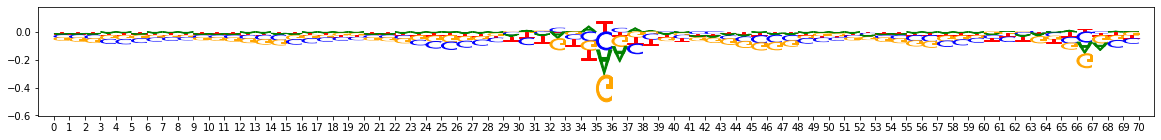

Task 0 actual importance scores:


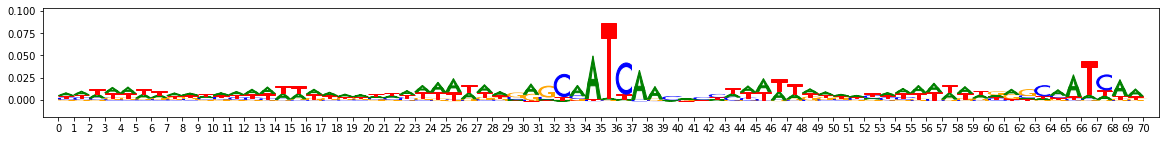

onehot, fwd and rev:


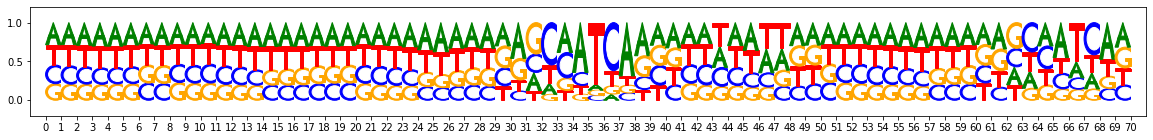

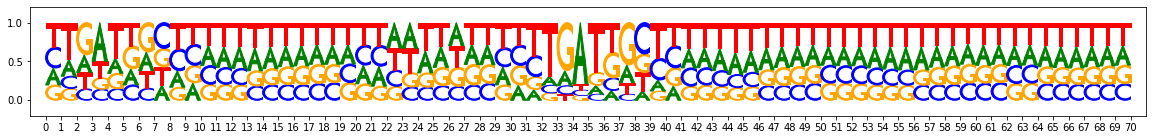

metacluster_0 pattern_1
total seqlets: 8613
Task 0 hypothetical scores:


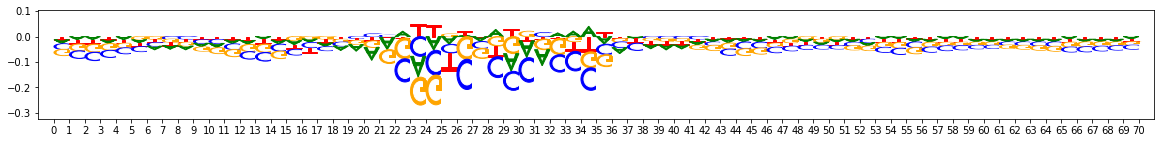

Task 0 actual importance scores:


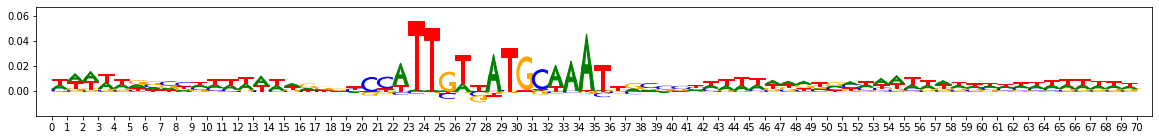

onehot, fwd and rev:


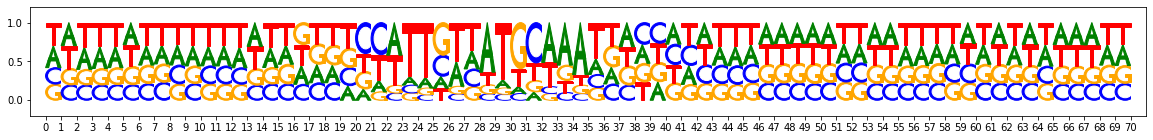

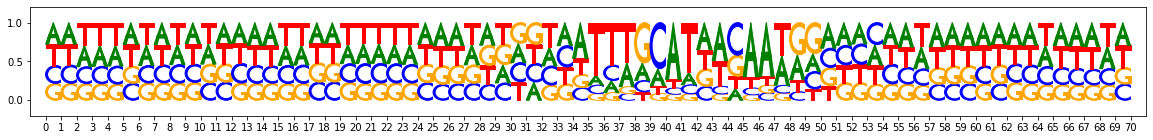

metacluster_0 pattern_2
total seqlets: 7252
Task 0 hypothetical scores:


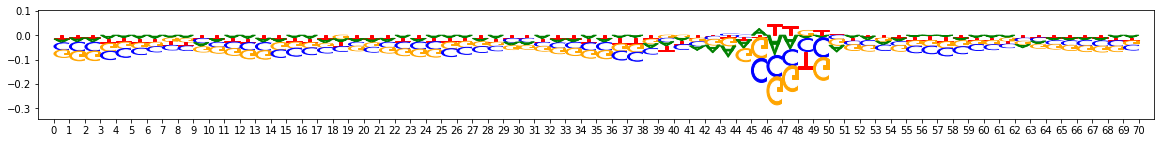

Task 0 actual importance scores:


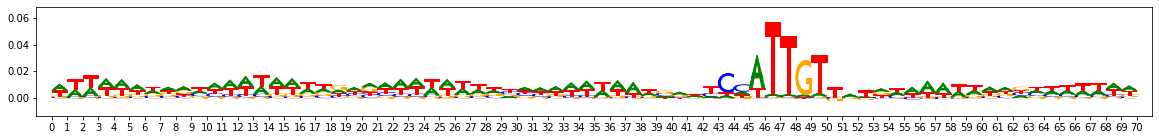

onehot, fwd and rev:


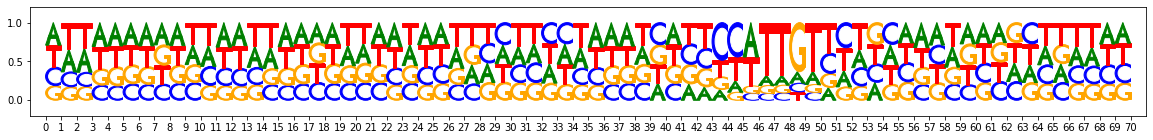

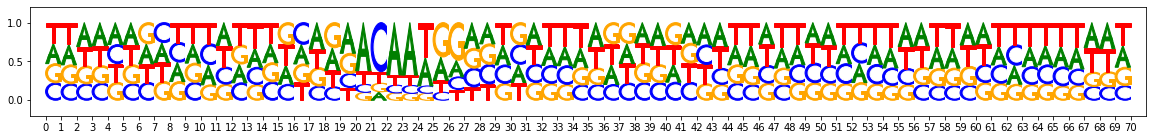

metacluster_0 pattern_3
total seqlets: 2718
Task 0 hypothetical scores:


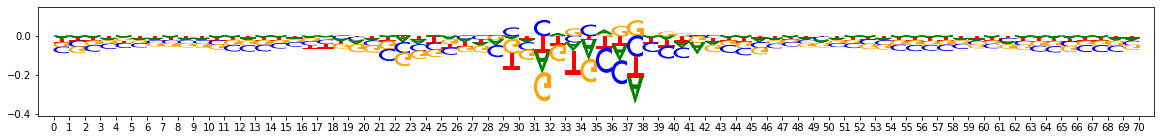

Task 0 actual importance scores:


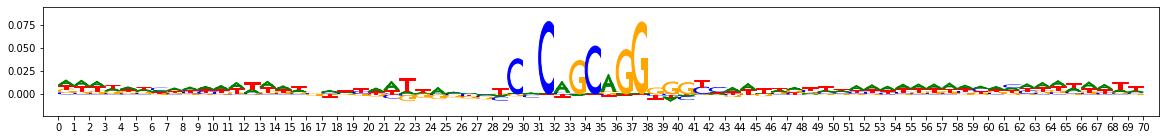

onehot, fwd and rev:


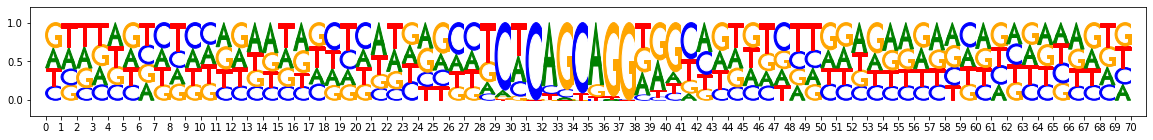

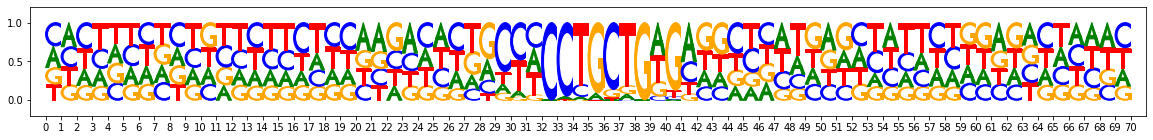

metacluster_0 pattern_4
total seqlets: 1506
Task 0 hypothetical scores:


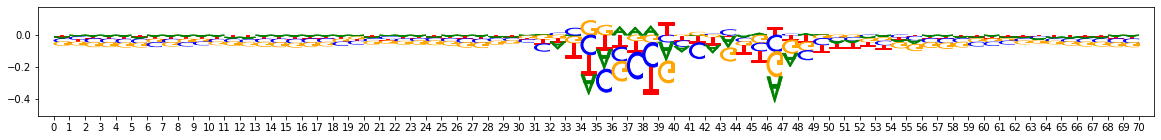

Task 0 actual importance scores:


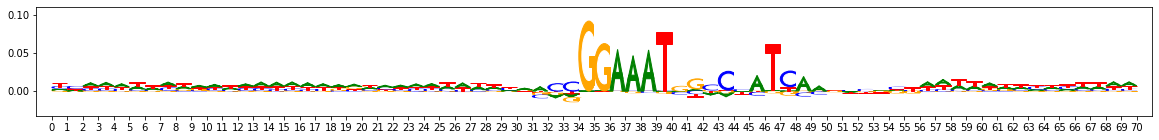

onehot, fwd and rev:


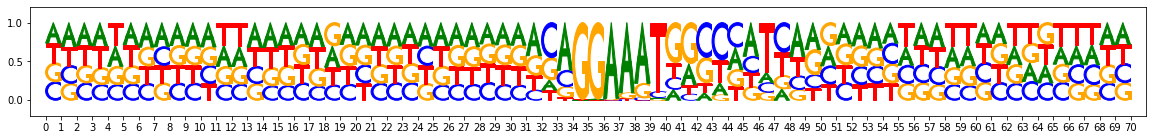

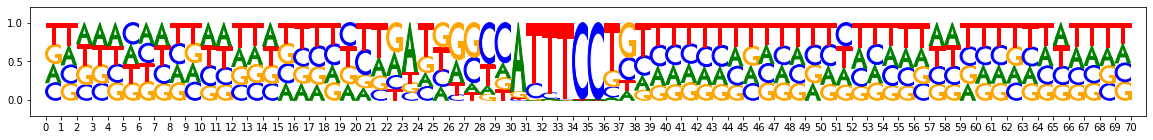

metacluster_0 pattern_5
total seqlets: 464
Task 0 hypothetical scores:


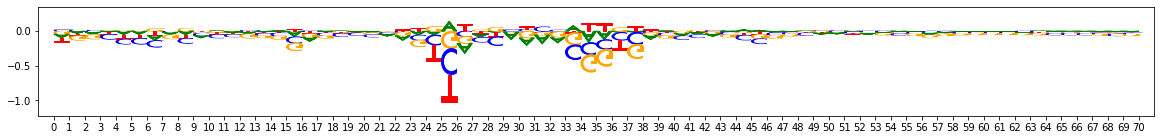

Task 0 actual importance scores:


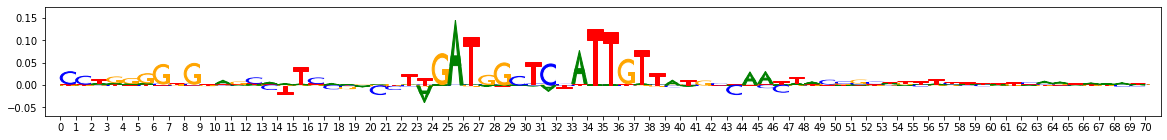

onehot, fwd and rev:


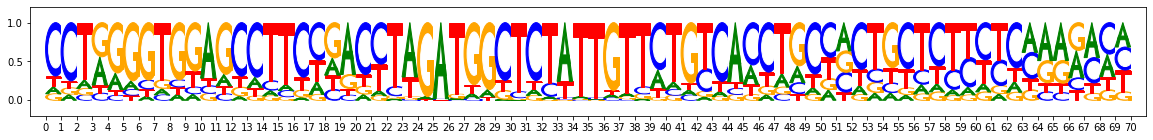

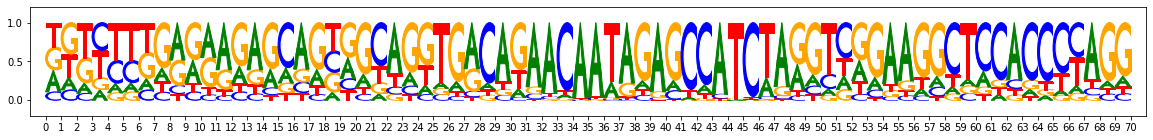

metacluster_0 pattern_6
total seqlets: 270
Task 0 hypothetical scores:


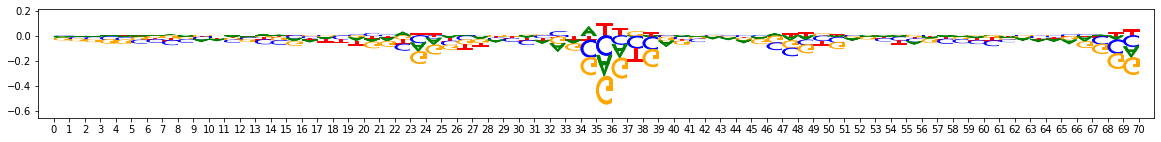

Task 0 actual importance scores:


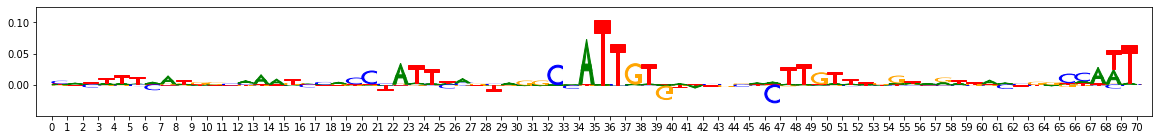

onehot, fwd and rev:


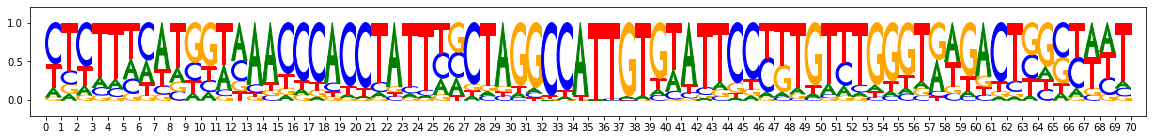

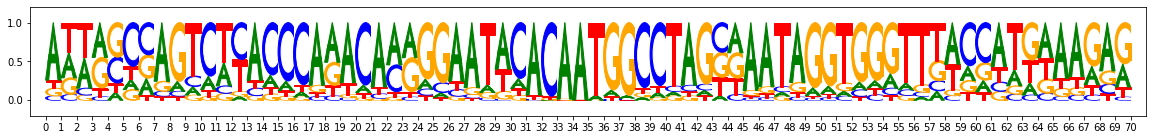

metacluster_0 pattern_7
total seqlets: 252
Task 0 hypothetical scores:


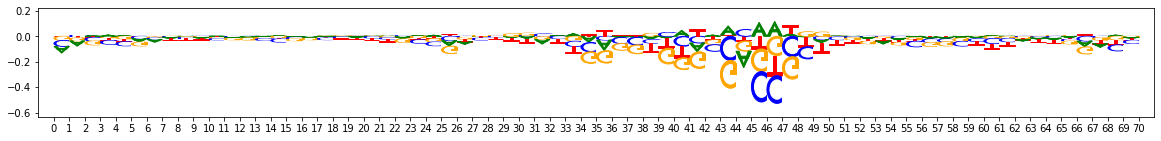

Task 0 actual importance scores:


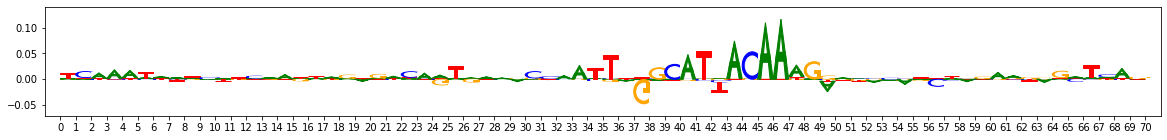

onehot, fwd and rev:


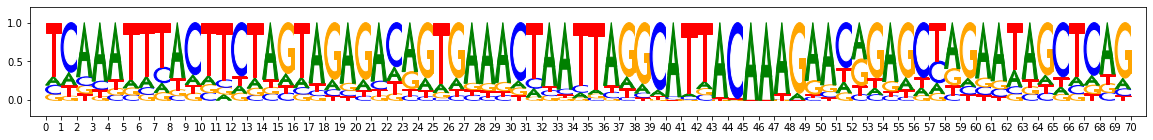

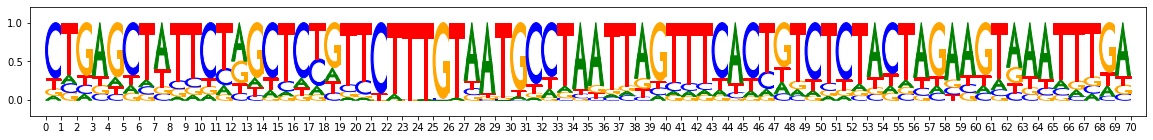

metacluster_0 pattern_8
total seqlets: 229
Task 0 hypothetical scores:


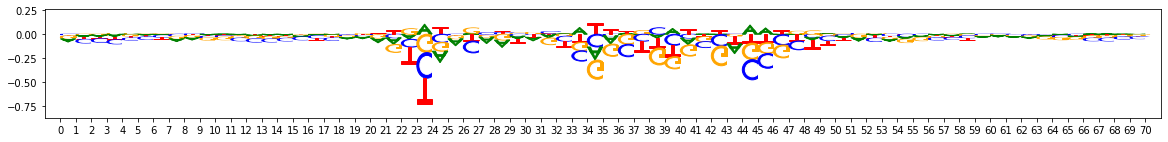

Task 0 actual importance scores:


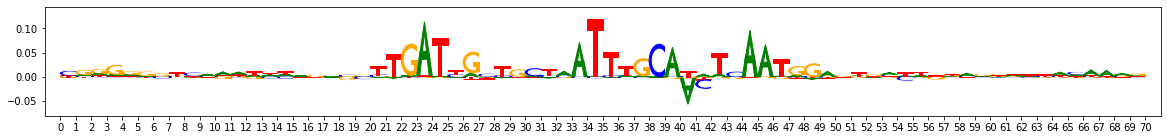

onehot, fwd and rev:


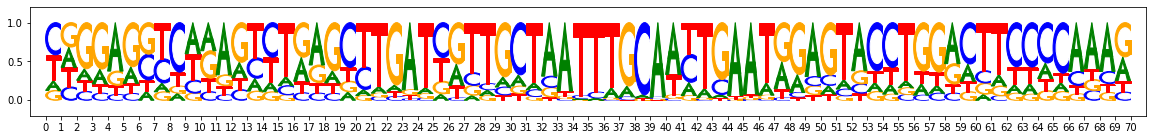

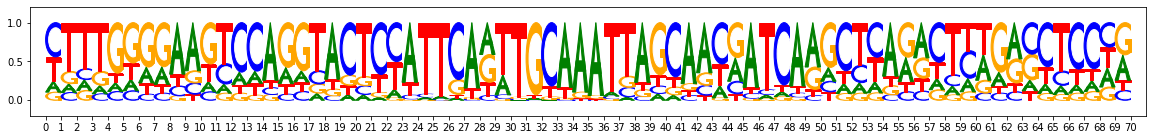

metacluster_0 pattern_9
total seqlets: 230
Task 0 hypothetical scores:


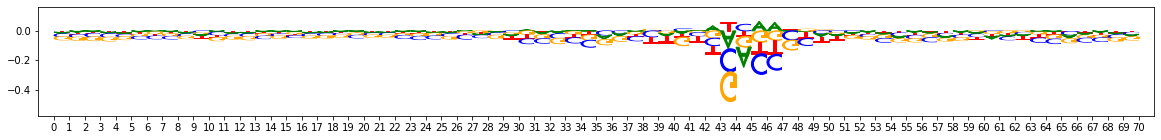

Task 0 actual importance scores:


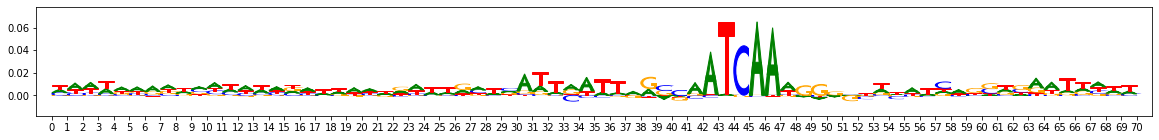

onehot, fwd and rev:


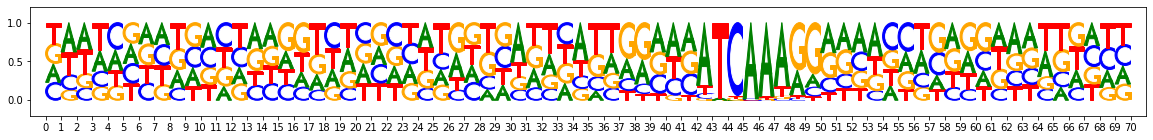

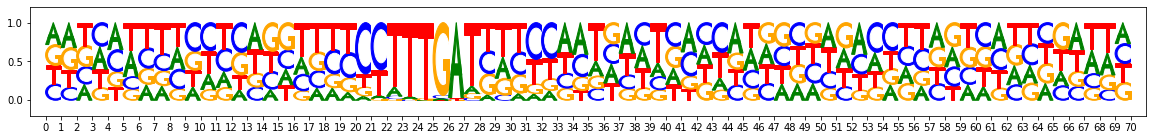

metacluster_0 pattern_10
total seqlets: 179
Task 0 hypothetical scores:


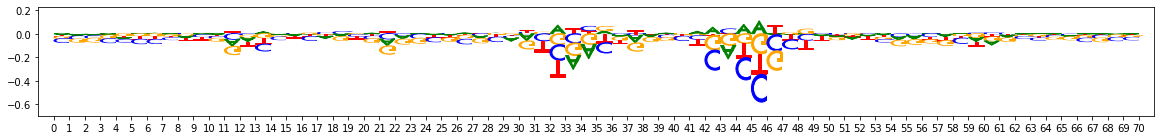

Task 0 actual importance scores:


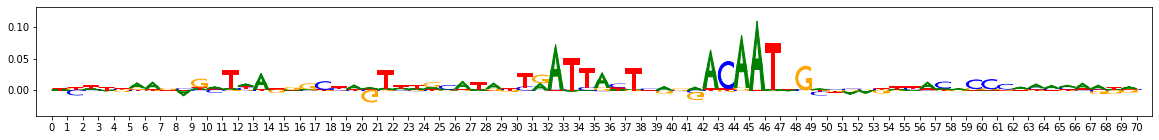

onehot, fwd and rev:


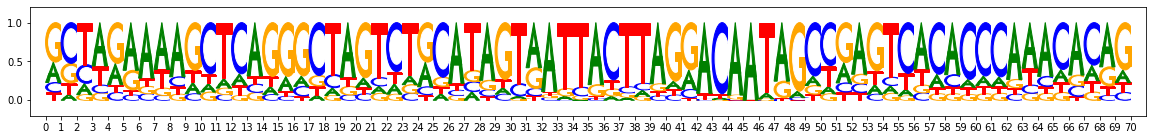

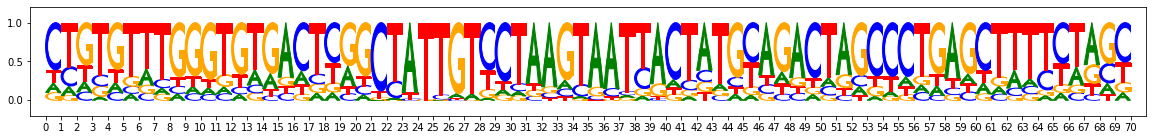

metacluster_0 pattern_11
total seqlets: 116
Task 0 hypothetical scores:


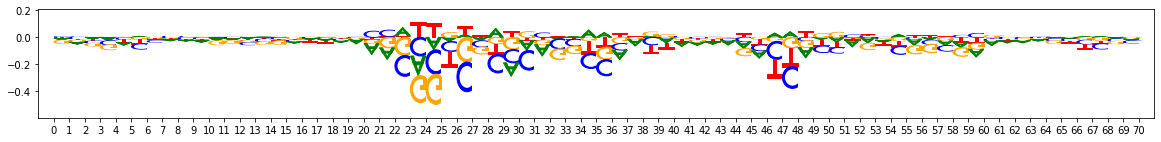

Task 0 actual importance scores:


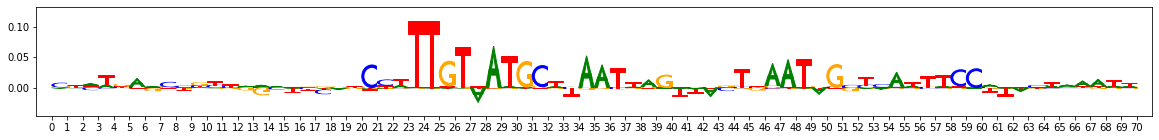

onehot, fwd and rev:


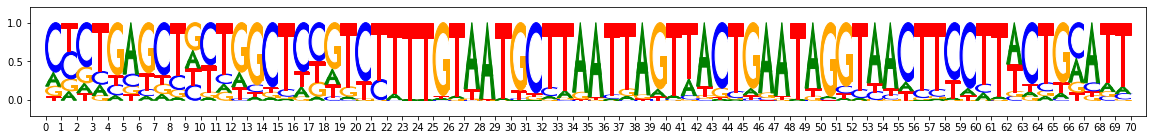

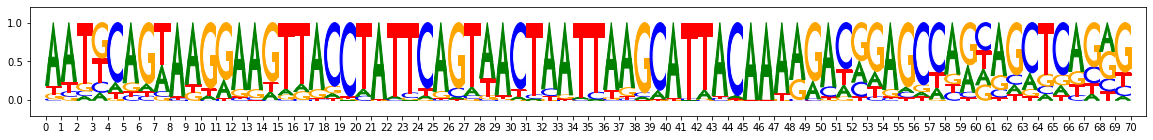

metacluster_0 pattern_12
total seqlets: 121
Task 0 hypothetical scores:


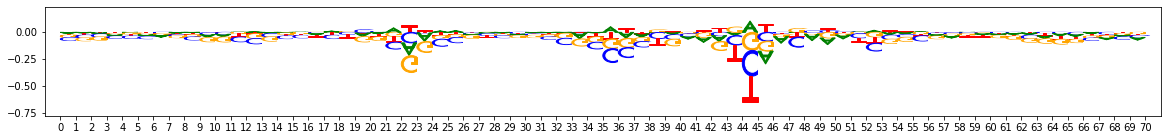

Task 0 actual importance scores:


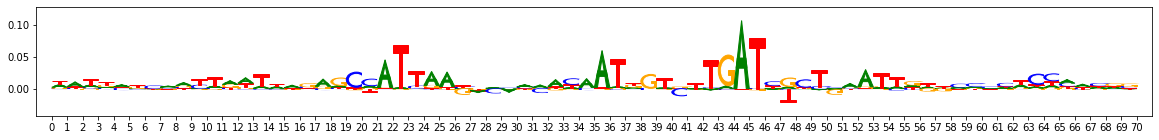

onehot, fwd and rev:


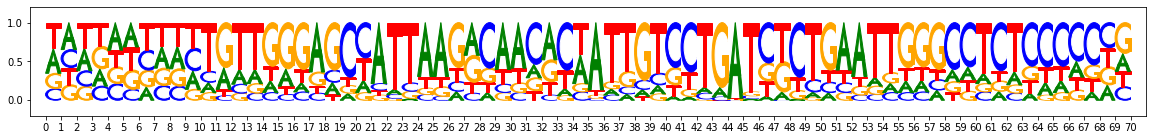

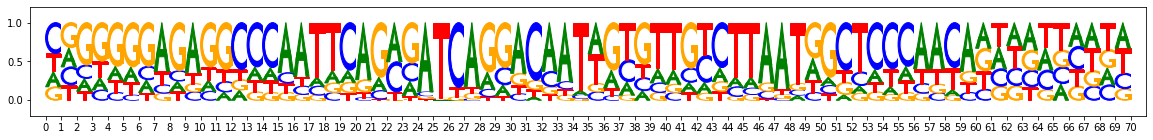

metacluster_0 pattern_13
total seqlets: 96
Task 0 hypothetical scores:


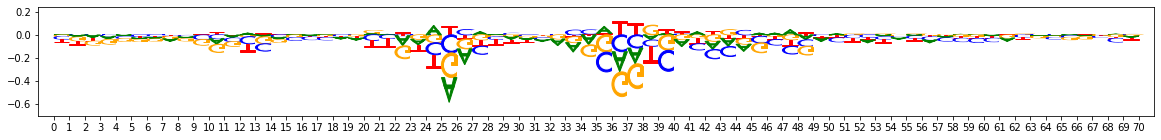

Task 0 actual importance scores:


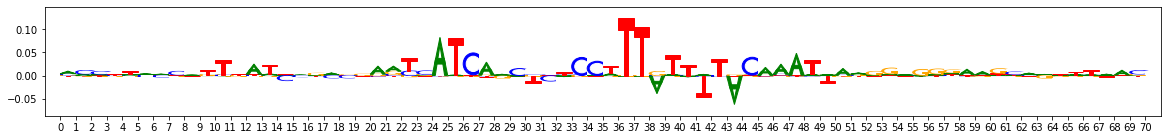

onehot, fwd and rev:


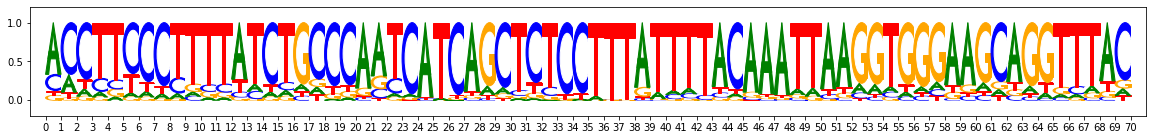

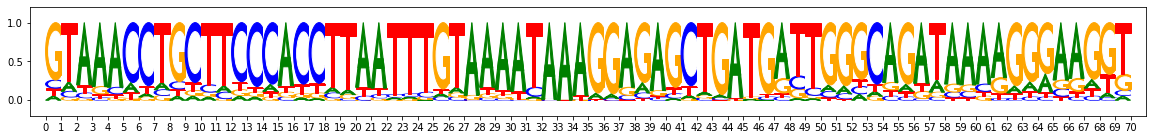

metacluster_0 pattern_14
total seqlets: 88
Task 0 hypothetical scores:


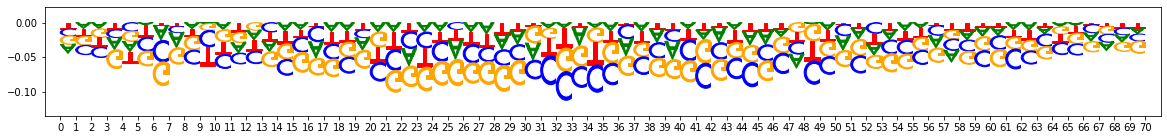

Task 0 actual importance scores:


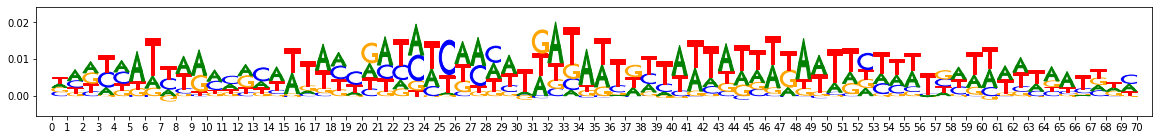

onehot, fwd and rev:


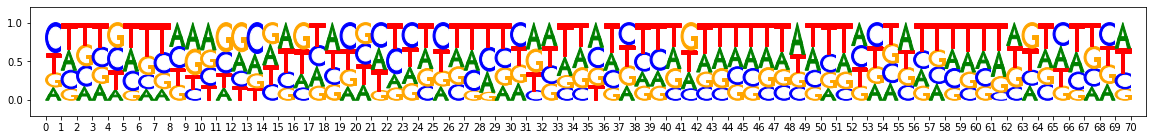

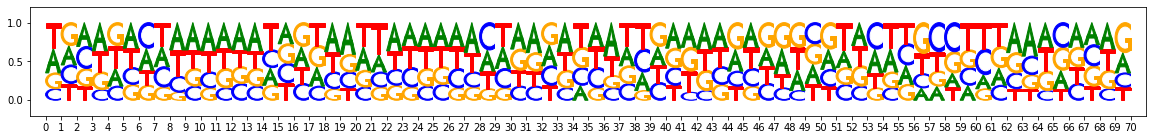

metacluster_0 pattern_15
total seqlets: 115
Task 0 hypothetical scores:


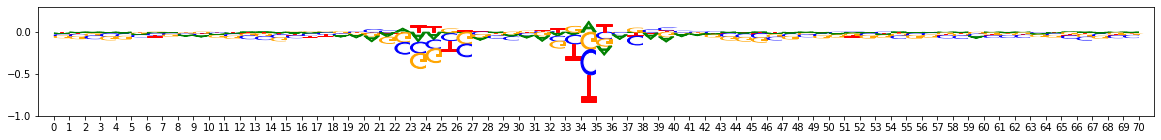

Task 0 actual importance scores:


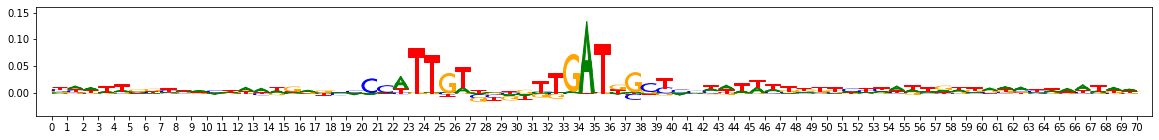

onehot, fwd and rev:


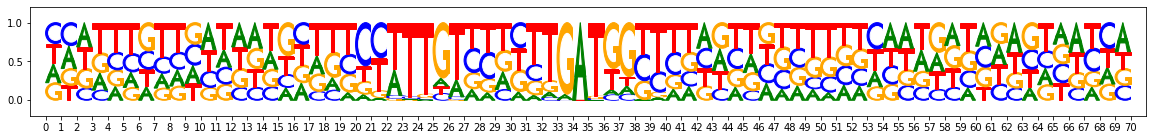

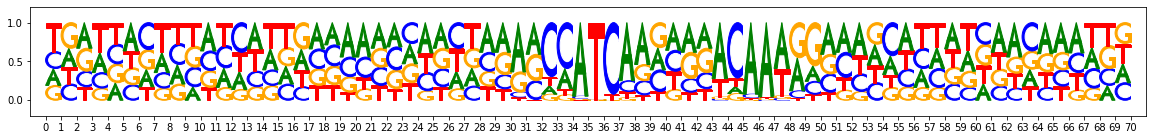

metacluster_0 pattern_16
total seqlets: 85
Task 0 hypothetical scores:


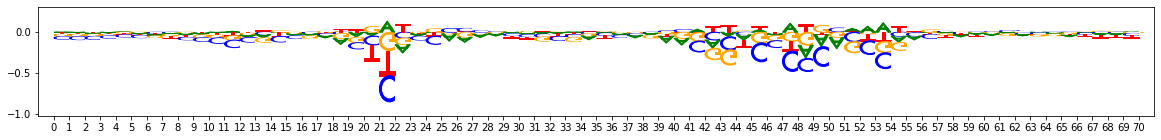

Task 0 actual importance scores:


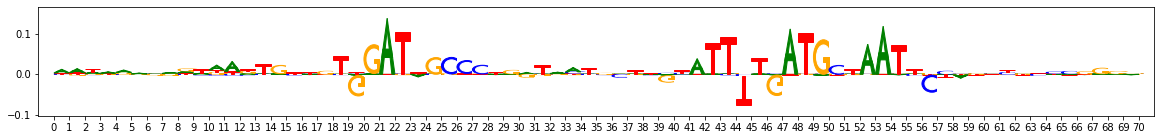

onehot, fwd and rev:


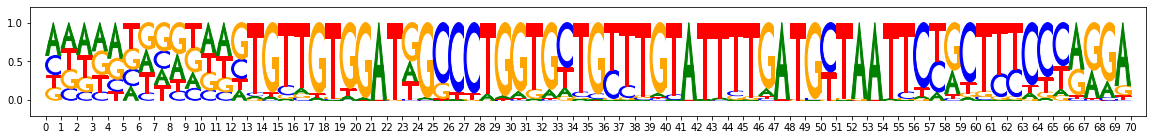

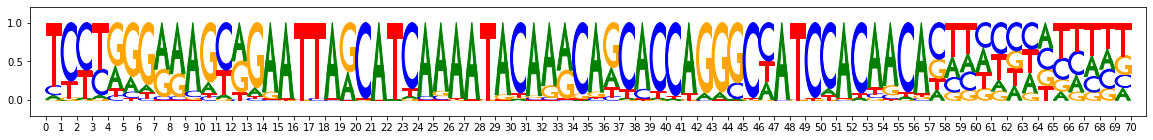

metacluster_0 pattern_17
total seqlets: 88
Task 0 hypothetical scores:


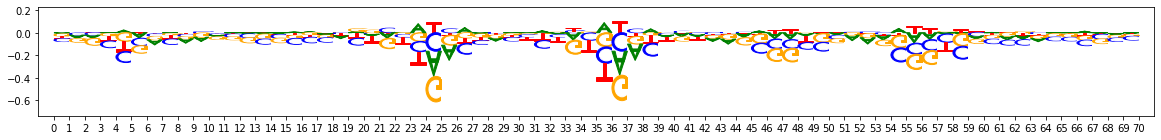

Task 0 actual importance scores:


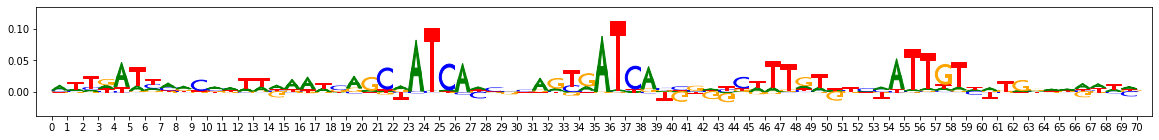

onehot, fwd and rev:


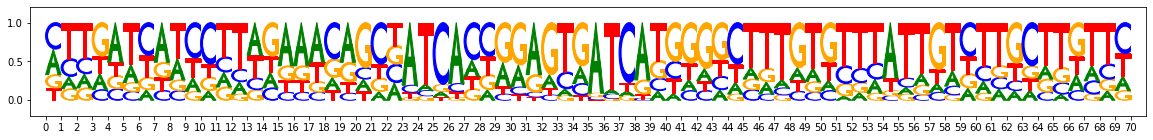

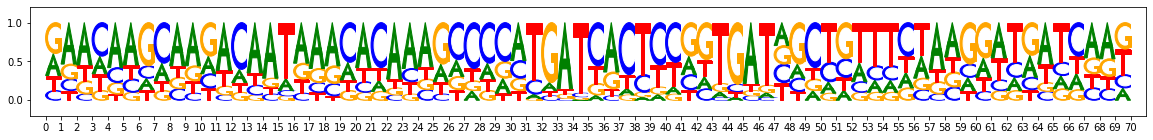

metacluster_0 pattern_18
total seqlets: 81
Task 0 hypothetical scores:


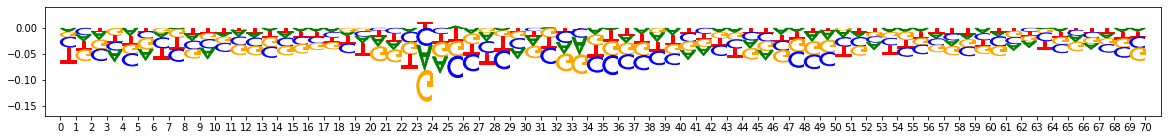

Task 0 actual importance scores:


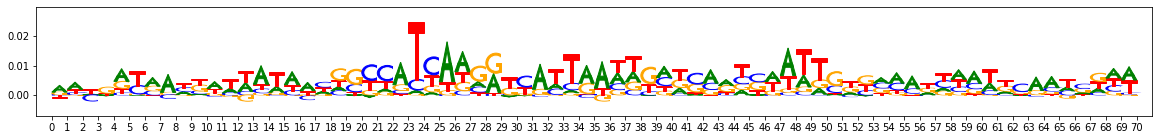

onehot, fwd and rev:


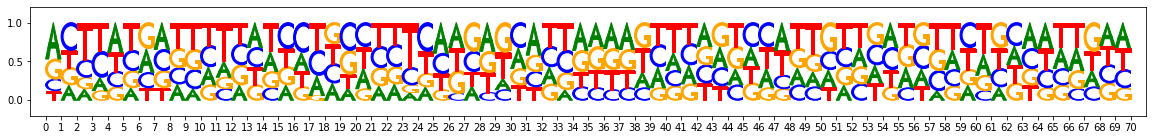

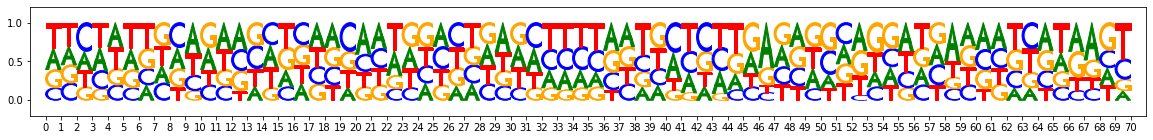

metacluster_0 pattern_19
total seqlets: 78
Task 0 hypothetical scores:


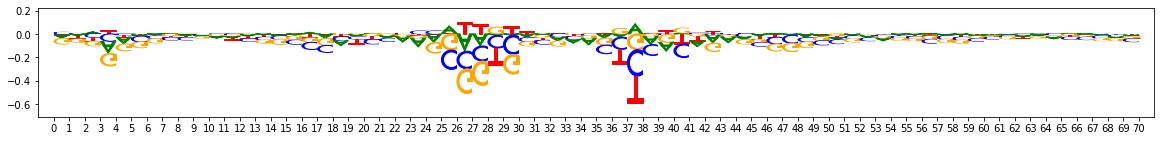

Task 0 actual importance scores:


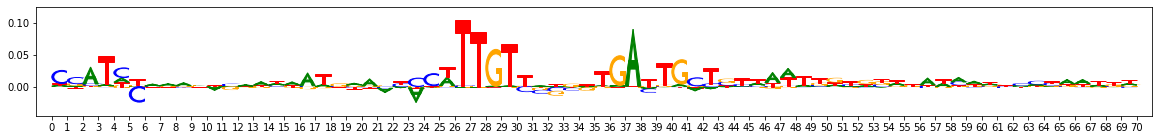

onehot, fwd and rev:


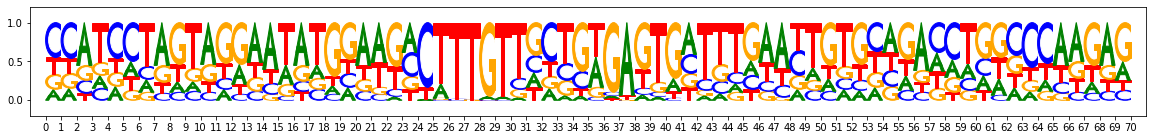

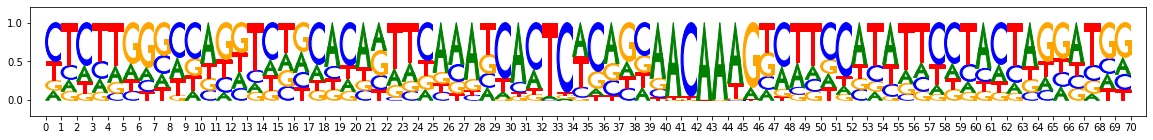

metacluster_0 pattern_20
total seqlets: 73
Task 0 hypothetical scores:


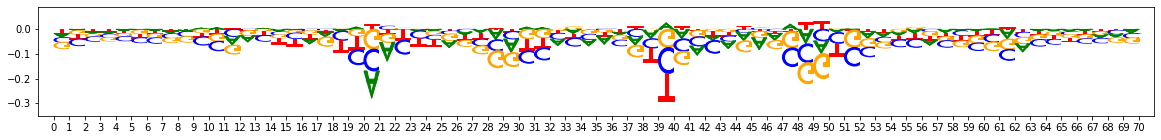

Task 0 actual importance scores:


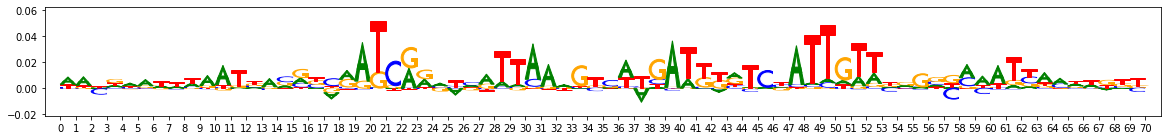

onehot, fwd and rev:


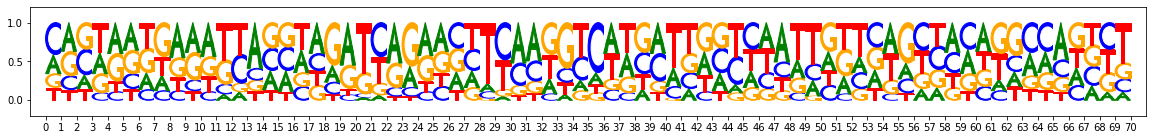

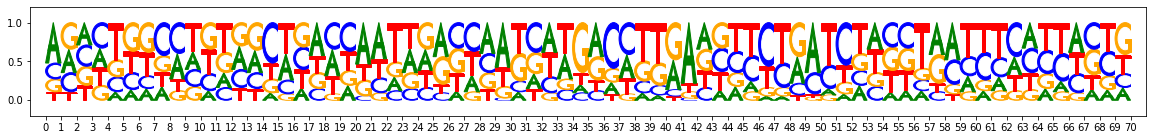

metacluster_0 pattern_21
total seqlets: 72
Task 0 hypothetical scores:


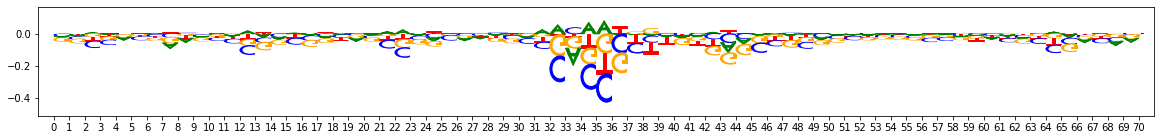

Task 0 actual importance scores:


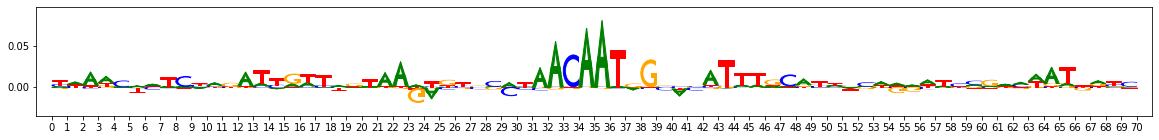

onehot, fwd and rev:


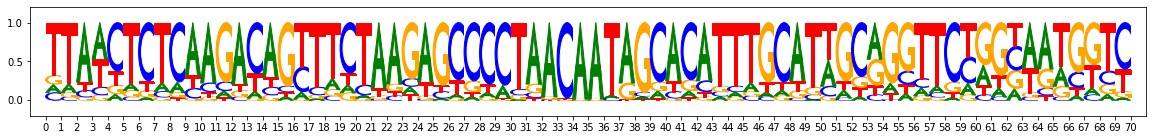

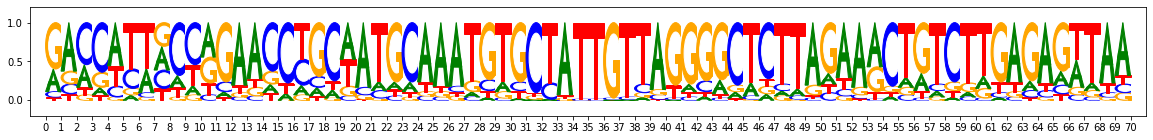

metacluster_0 pattern_22
total seqlets: 56
Task 0 hypothetical scores:


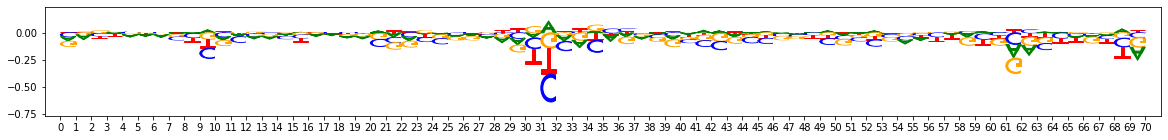

Task 0 actual importance scores:


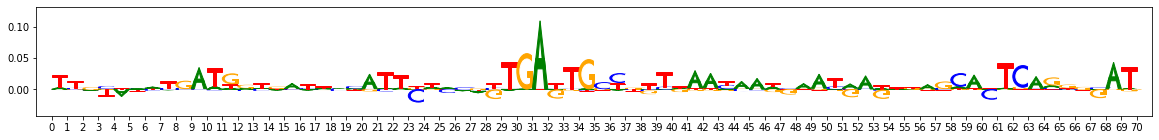

onehot, fwd and rev:


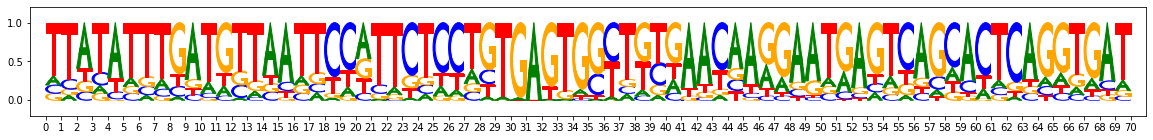

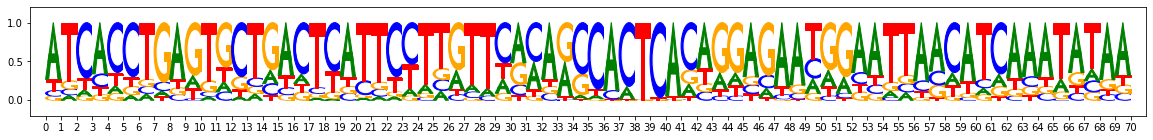

metacluster_0 pattern_23
total seqlets: 63
Task 0 hypothetical scores:


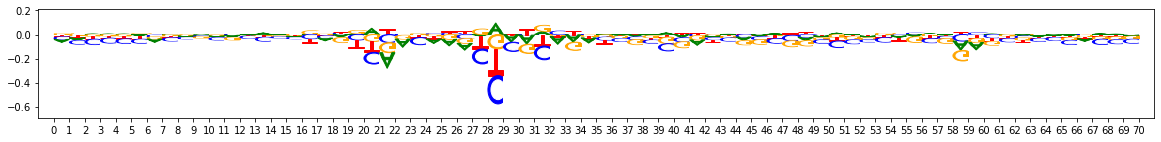

Task 0 actual importance scores:


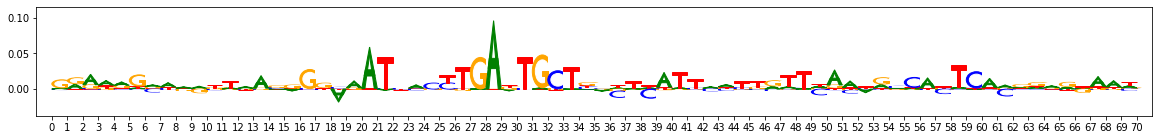

onehot, fwd and rev:


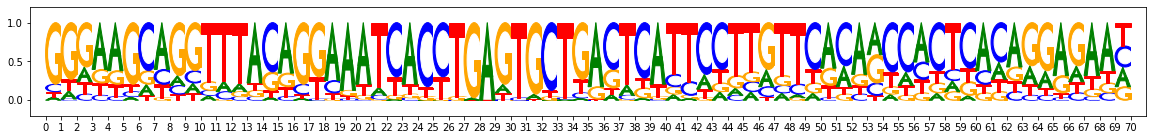

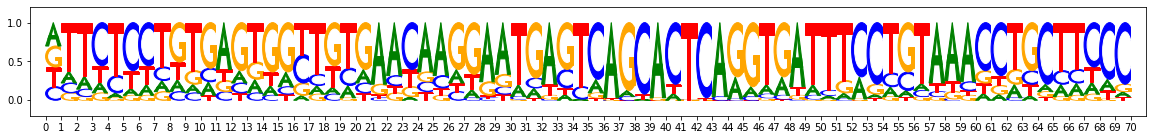

metacluster_0 pattern_24
total seqlets: 43
Task 0 hypothetical scores:


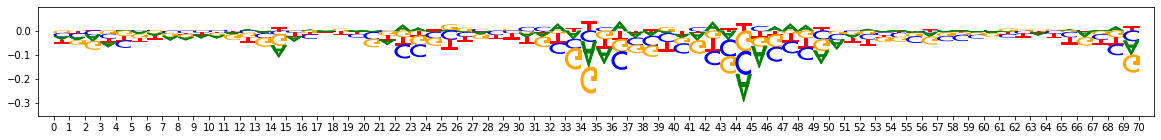

Task 0 actual importance scores:


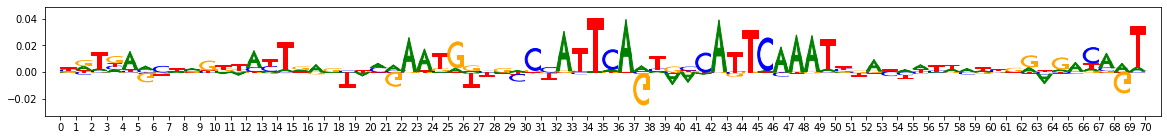

onehot, fwd and rev:


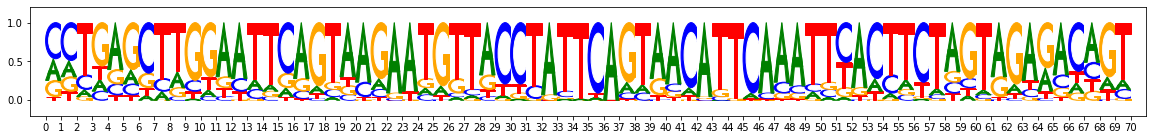

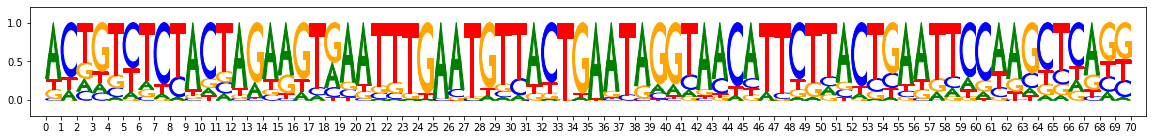

metacluster_0 pattern_25
total seqlets: 39
Task 0 hypothetical scores:


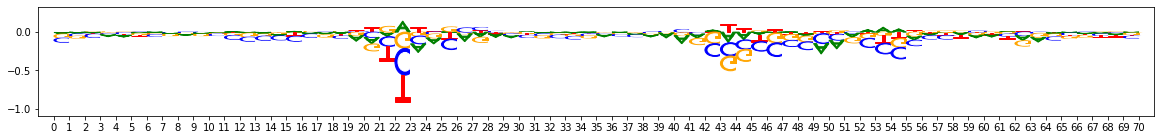

Task 0 actual importance scores:


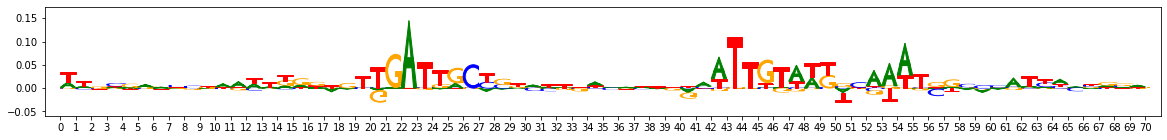

onehot, fwd and rev:


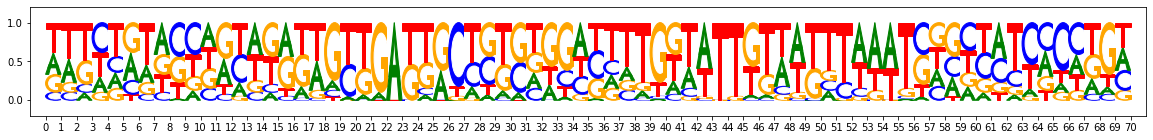

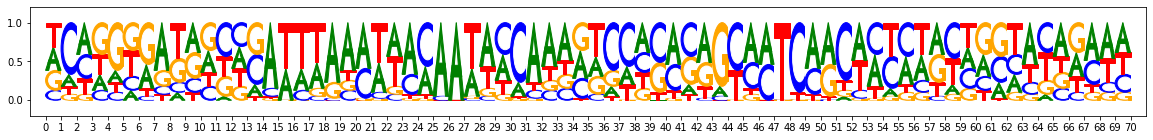

metacluster_0 pattern_26
total seqlets: 48
Task 0 hypothetical scores:


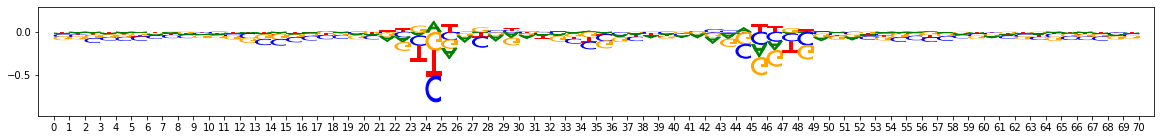

Task 0 actual importance scores:


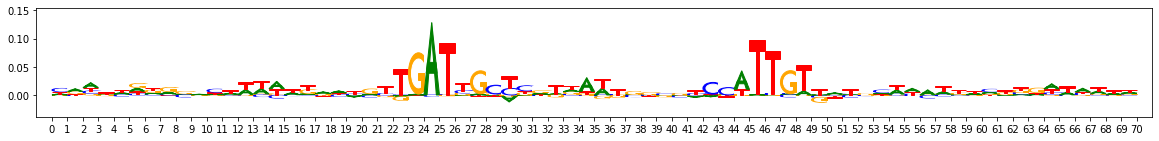

onehot, fwd and rev:


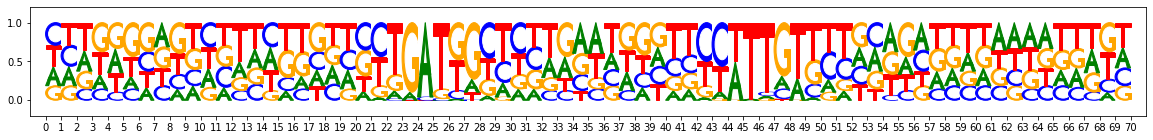

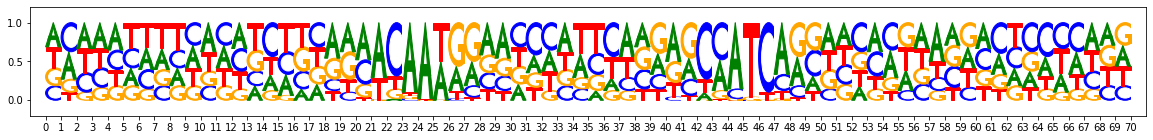

metacluster_0 pattern_27
total seqlets: 47
Task 0 hypothetical scores:


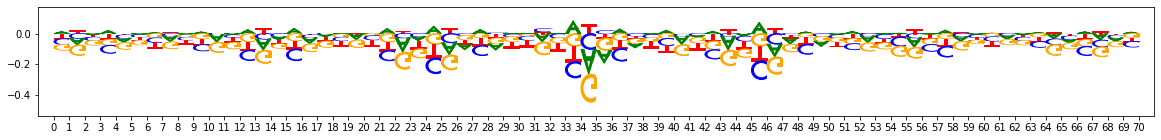

Task 0 actual importance scores:


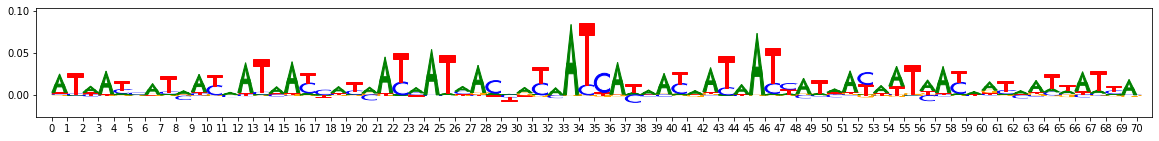

onehot, fwd and rev:


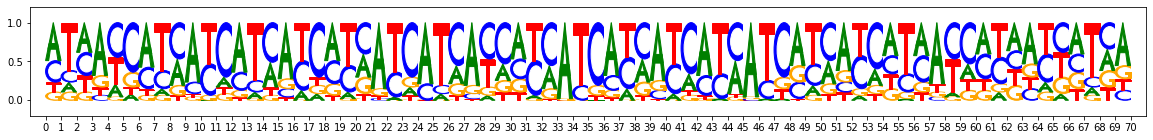

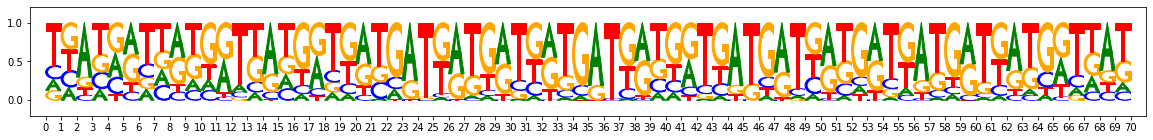

metacluster_0 pattern_28
total seqlets: 50
Task 0 hypothetical scores:


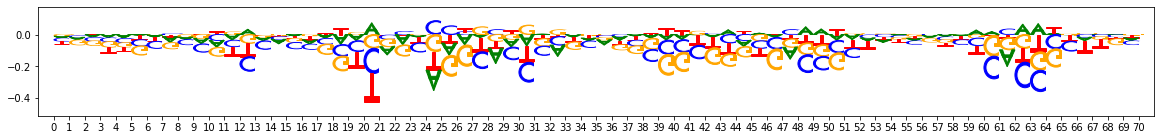

Task 0 actual importance scores:


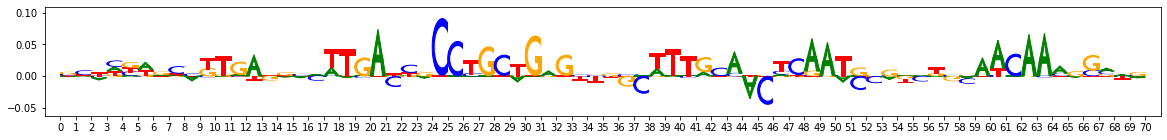

onehot, fwd and rev:


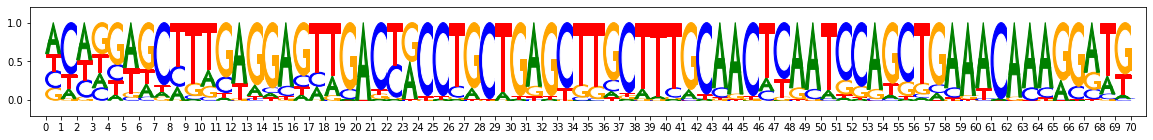

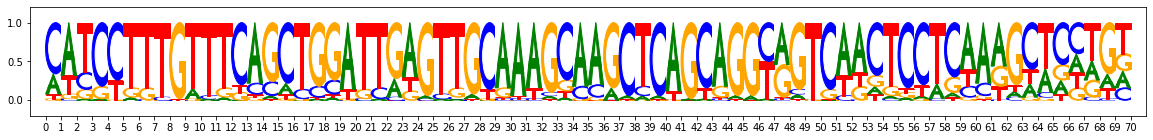

In [42]:
from modisco.visualization import viz_sequence
%matplotlib inline

hdf5_results = h5py.File(file_path,"r")

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(np.array(pattern["sequence"]["fwd"])) 
        viz_sequence.plot_weights(np.array(pattern["sequence"]["rev"])) 
        
hdf5_results.close()